In [2]:
import pipit as pp
import pandas as pd
import pipit.plotting.core as vis
from pipit.partitions import Event, Partition

### Load Dataset

In [3]:
#Path to OTF2 traces
dirname = "../../pipit/tests/data/ping-pong-otf2"

# Use pipit's ``from_otf2`` API to read in the OTF2 traces.
# The result is stored into pipit's Trace data structure.
trace = pp.Trace.from_otf2(dirname)

# Printout the DataFrame component of the Trace.
display (trace.events.columns)
display (trace.events[trace.events['Process'] == 0].head(40))
display (trace.events.loc[17]['Attributes'])

Index(['Timestamp (ns)', 'Event Type', 'Name', 'Thread', 'Process',
       'Attributes'],
      dtype='object')

,Timestamp (ns),Event Type,Name,Thread,Process,Attributes
3,3.077309e+05,Instant,ProgramBegin,0,0,"{'attributes': {'Attribute 2': 26601}, 'progra..."
4,3.369797e+05,Enter,"int main(int, char**)",0,0,{'region': 'Region 3'}
5,3.460548e+05,Enter,MPI_Init,0,0,{'region': 'Region 148'}
6,1.936431e+08,Leave,MPI_Init,0,0,None
8,1.936516e+08,Enter,MPI_Comm_size,0,0,{'region': 'Region 37'}
10,1.936532e+08,Leave,MPI_Comm_size,0,0,None
12,1.936557e+08,Enter,MPI_Comm_rank,0,0,{'region': 'Region 34'}
14,1.936568e+08,Leave,MPI_Comm_rank,0,0,None
16,1.936682e+08,Enter,MPI_Send,0,0,{'region': 'Region 193'}
17,1.936726e+08,Instant,MpiSend,0,0,"{'receiver': 1, 'communicator': 'Comm 1', 'msg..."


{'receiver': 1, 'communicator': 'Comm 1', 'msg_tag': 10, 'msg_length': 16384}

In [4]:
# Plot Timeline
trace.plot_timeline()


### Matching MPI Events

In [5]:
trace._match_mpi()

In [6]:
# Get a filtered event dataframe with only MPI events.
mpi_trace = trace.events[trace.events['Name'].str.contains('MpiSend|MpiRecv')]
display (mpi_trace.loc[17])

Timestamp (ns)                                          193672584.566855
Event Type                                                       Instant
Name                                                             MpiSend
Thread                                                                 0
Process                                                                0
Attributes             {'receiver': 1, 'communicator': 'Comm 1', 'msg...
_matching_event                                                       21
_matching_timestamp                                     193691633.370326
_depth                                                               NaN
_parent                                                              NaN
_children                                                           None
time.inc                                                             NaN
time.exc                                                             NaN
Name: 17, dtype: object

In [7]:
def _get_mpi_matching_df(trace):
    """Get an intermediate DataFrame with matching MPI Sends and Recvs .
    """
    mpi_trace = trace.events[trace.events['Name'].str.contains('MpiSend|MpiRecv')]

    columns = ['id', 'matching_id', 'process', 'receive_from', 'send_to', 'time']
    matching_mpi_df = pd.DataFrame(columns=columns)

    for index, row in mpi_trace.iterrows():
        if row['Name'] == 'MpiSend':
            process = row['Process']
            matching_process = mpi_trace.loc[row['_matching_event']]['Process']
            send_time = row['Timestamp (ns)']
            recv_time = row['_matching_timestamp']

            # Add pair of matching send and receives
            matching_mpi_df = pd.concat([matching_mpi_df, pd.DataFrame([{'id': index, 'matching_id': row['_matching_event'], 'process': process, 'receive_from': None, 'send_to': matching_process, 'time': send_time }])], ignore_index=True)
            matching_mpi_df = pd.concat([matching_mpi_df, pd.DataFrame([{'id': row['_matching_event'], 'matching_id': index, 'process': matching_process, 'receive_from': process, 'send_to': None, 'time': recv_time }])], ignore_index=True)
    matching_mpi_df = matching_mpi_df.sort_values(by=['time'])
    return matching_mpi_df

In [8]:
mpi_matching_df = _get_mpi_matching_df(trace)
display (mpi_matching_df)

,id,matching_id,process,receive_from,send_to,time
0,17,21,0,None,1,1.936726e+08
1,21,17,1,0,None,1.936916e+08
2,24,26,1,None,0,1.936998e+08
3,26,24,0,1,None,1.937157e+08
4,30,32,0,None,1,1.937444e+08
5,32,30,1,0,None,1.937648e+08
6,36,38,1,None,0,1.937656e+08
7,38,36,0,1,None,1.937842e+08
8,42,43,0,None,1,1.938260e+08
9,43,42,1,0,None,1.938511e+08


In [9]:
# Get all processes that have MPI events
unique_processes = trace.events['Process'].unique().tolist()
unique_processes.sort()

print((unique_processes[0]))

0


### Create Event Graph (Linked List)

In [10]:
def _get_event_graph(trace):
    """ Get event graph from trace

    Parameters
    ----------
    trace : pipit.Trace
        Trace object
    
    Returns
    -------
        start_event_list : list
            List of start events
        event_dict : dict
            Dictionary of all events with event id as key and event object as value
    """

    # Get matching_mpi_df from trace for easier event matching 
    # TODO: This can be removed and the full trace can be used for event matching
    matching_mpi_df = _get_mpi_matching_df(trace)

    unique_processes = mpi_matching_df['process'].unique()


    # List of start events - one for each process
    start_event_ids = []

    # Dictionary of all events with event id as key and event object as value
    # Does not include the start event and event id is the index of the event in the trace
    event_dict = {}

    for process in unique_processes:
        process_filtered_events = trace.events[(trace.events['Process'] == process)]

        prev_event = None
        prev_event_row = None
        for index, event_row in process_filtered_events.iterrows():
            event = None

            if event_row['Event Type'] == 'Instant':
                # The first event for every process should be ProgramBegin and this will be our start event
                if event_row['Name'] == 'ProgramBegin' or event_row['Name'] == 'ProgramEnd':
                    event = Event(event_row['Name'], event_row['Event Type'], index, event_row['Timestamp (ns)'], process)
                    if event_row['Name'] == 'ProgramBegin':
                        start_event_ids.append(index)
                elif event_row['Name'] == 'MpiSend' or event_row['Name'] == 'MpiRecv':
                    # Only for MPI events, we care about the matching event for now
                    # Assumption - For a particular (process, thread) MPI Enter, Instant and Leave will be in that order and that order only
                    event = Event(event_row['Name'], event_row['Event Type'], index, event_row['Timestamp (ns)'], process, event_row['_matching_event'])
                    event.add_start_time(prev_event_row['Timestamp (ns)'])

                if prev_event is not None:
                    event.add_prev_event(prev_event)
                    prev_event.add_next_event(event)

                event_dict[index] = event
                prev_event = event

            elif event_row['Event Type'] == 'Enter':
                pass
            elif event_row['Event Type'] == 'Leave':
                # For Leave events, we need to add the end time to the prev event
                if event_row['Name'] == 'MPI_Send' or event_row['Name'] == 'MPI_Recv':
                    prev_event.add_end_time(event_row['Timestamp (ns)'])
                
            prev_event_row = event_row

    # Iteratate through all events and store the object of the matching event in the current event
    for start_event_id in start_event_ids:
        event = event_dict[start_event_id]
        while event is not None:
            if event.matching_event_id != -1:
                event.add_matching_event(event_dict[event.matching_event_id])
            event = event.get_next_event()

    return (start_event_ids, event_dict)


start_event_ids, event_dict = _get_event_graph(trace)
    
for se in start_event_ids:
    event = event_dict[se]
    while event is not None:
        if event.has_matching_event():
            print (f"({event.process}, {event.event_id}, {event.event_name}, {event.start_time}, {event.end_time}, {event.get_matching_event().event_id})", end = '->')
        else:
            print (f"({event.process}, {event.event_id}, {event.event_name}, {event.start_time}, {event.end_time})", end = '->')
        event = event.get_next_event()
    print()

(0, 3, ProgramBegin, 307730.9358165928, 307730.9358165928)->(0, 17, MpiSend, 193668225.07270837, 193685930.32723847, 21)->(0, 26, MpiRecv, 193687379.3555098, 193718856.106002, 24)->(0, 30, MpiSend, 193743866.6394257, 193764550.13388103, 32)->(0, 38, MpiRecv, 193764846.04874542, 193784513.88702112, 36)->(0, 42, MpiSend, 193825567.77891403, 193854930.16997212, 43)->(0, 49, MpiRecv, 193855196.49335006, 193889995.12683582, 46)->(0, 53, MpiSend, 193942036.05127355, 193995956.51238206, 55)->(0, 61, MpiRecv, 193996173.19842792, 194050442.07542512, 58)->(0, 65, MpiSend, 194205281.91461667, 194302812.59022063, 67)->(0, 73, MpiRecv, 194303143.8239559, 194409224.53001198, 70)->(0, 77, MpiSend, 194675378.9501026, 194911489.42038304, 79)->(0, 86, MpiRecv, 194911733.78878716, 195132209.45402402, 82)->(0, 89, MpiSend, 195717989.1556328, 196139793.8398177, 91)->(0, 98, MpiRecv, 196140050.61755484, 196584467.97019798, 94)->(0, 101, MpiSend, 197613248.45135725, 198506398.7408429, 103)->(0, 110, MpiRecv,

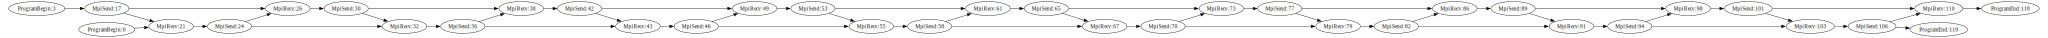

In [11]:
# Visualise Event Graph
from graphviz import Digraph

# Function to create a DOT representation of linked lists
def linked_lists_to_dot(start_event_ids, dict):
    dot = Digraph(comment='Process Event Graph')

    for i, se in enumerate(start_event_ids):
        current_node = dict[se]
        while current_node:
            dot.node(f"{current_node.event_id}_{current_node.event_name}", str(current_node.event_name) + ":" + str(current_node.event_id))
            if current_node.get_next_event():
                dot.edge(f"{current_node.event_id}_{current_node.event_name}", f"{current_node.get_next_event().event_id}_{current_node.get_next_event().event_name}")

            if current_node.event_name == 'MpiSend' and current_node.has_matching_event():
                dot.edge(f"{current_node.event_id}_{current_node.event_name}", f"{current_node.get_matching_event().event_id}_{current_node.get_matching_event().event_name}")
            current_node = current_node.get_next_event()

    return dot

# Create a DOT representation
dot_representation = linked_lists_to_dot(start_event_ids, event_dict)
dot_representation.attr(rankdir='LR')  
# Display the DOT representation in a Jupyter Notebook (optional)
dot_representation


### Create Partition Graph

In [13]:
# Implement Merging of Partitions
def get_partition_graph(trace):
    """ Get partition graph from trace

    Parameters
    ----------
    trace : pipit.Trace
        Trace object
    
    Returns
    -------
    start_partition_ids : list
        List of start partition ids
    partition_list : list
        List of partitions
    """

    start_event_ids, event_dict = _get_event_graph(trace)

    partition_list = []
    start_partition_ids = []

    event_to_partition = {} # event_id -> partition_id

    # Create a singleton partition for every event
    for start_event in start_event_ids:
        event = event_dict[start_event]
        while event is not None:
            if event.has_matching_event() and (event.matching_event_id in event_to_partition.keys()):
                # If the matching event is already in a partition, add the current event to that partition
                partition_list[event_to_partition[event.matching_event_id]].add_event(event) # Also sets the partition to the event
                event_to_partition[event.event_id] = event_to_partition[event.matching_event_id]
            else:
                partition_id = len(partition_list)
                partition_list.append(Partition(partition_id, [event]))
                event_to_partition[event.event_id] = partition_id

            if event.event_name == "ProgramBegin":
                start_partition_ids.append(event_to_partition[event.event_id])

            event = event.next_event

    return (start_partition_ids, partition_list)


start_partition_ids, partition_list = get_partition_graph(trace)
print (start_partition_ids)


for partition in partition_list:
    print (f"{partition.partition_id} - {partition.event_list}")

[0, 18]
0 - [<pipit.partitions.event.Event object at 0x1776cf2d0>]
1 - [<pipit.partitions.event.Event object at 0x1776dbf50>, <pipit.partitions.event.Event object at 0x1776da650>]
2 - [<pipit.partitions.event.Event object at 0x1776da990>, <pipit.partitions.event.Event object at 0x177638650>]
3 - [<pipit.partitions.event.Event object at 0x1776db510>, <pipit.partitions.event.Event object at 0x177638c10>]
4 - [<pipit.partitions.event.Event object at 0x1776d9e10>, <pipit.partitions.event.Event object at 0x177638290>]
5 - [<pipit.partitions.event.Event object at 0x1776dab50>, <pipit.partitions.event.Event object at 0x17763b610>]
6 - [<pipit.partitions.event.Event object at 0x1776d8ad0>, <pipit.partitions.event.Event object at 0x177639790>]
7 - [<pipit.partitions.event.Event object at 0x17763a390>, <pipit.partitions.event.Event object at 0x177643ad0>]
8 - [<pipit.partitions.event.Event object at 0x17761af10>, <pipit.partitions.event.Event object at 0x177641510>]
9 - [<pipit.partitions.event.

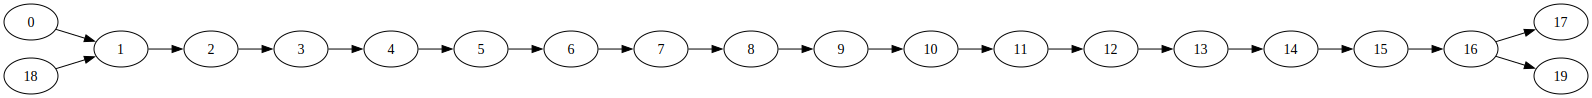

ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=1187&bokeh-absolute-url=http://localhost:52545&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:52545', method='GET', uri='/autoload.js?bokeh-autoload-element=1187&bokeh-absolute-url=http://localhost:52545&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/Users/prajwalsinghania/opt/anaconda3/envs/pipit/lib/python3.11/site-packages/tornado/web.py", line 1786, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "/Users/prajwalsinghania/opt/anaconda3/envs/pipit/lib/python3.11/site-packages/bokeh/server/views/autoload_js_handler.py", line 62, in get
    session = await self.get_session()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/prajwalsinghania/opt/anaconda3/envs/pipit/lib/python3.11/site-packages/bokeh/server/views/session_handler.py", line 144, in get_session
    session = await self.application_context

In [14]:
from graphviz import Digraph

visited = []

# Function to create a DOT representation of linked lists
def visualise(start_ids, partition_list, dot=None):
    if dot is None:
        dot = Digraph(comment='Partition Graph')

    for i, sp in enumerate(start_ids):
        current_partition = partition_list[sp]
        if current_partition.partition_id in visited:
            return dot
        dot.node(f"{current_partition.partition_id}", str(current_partition.partition_id))
        visited.append(current_partition.partition_id)
        children_ids = current_partition.get_children()
        for child_id in children_ids:
            child_partition = partition_list[child_id]
            dot = visualise([child_id], partition_list, dot)
            dot.edge(f"{current_partition.partition_id}", f"{child_partition.partition_id}")
    return dot

 # Sample linked lists

# Create a DOT representation
dot_representation = visualise(start_partition_ids, partition_list)
dot_representation.attr(rankdir='LR')  
# Display the DOT representation in a Jupyter Notebook (optional)
dot_representation